In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.metrics import log_loss, accuracy_score, classification_report, plot_confusion_matrix, balanced_accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

from nltk import word_tokenize

%matplotlib inline
sns.set()

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sample = pd.read_csv('../input/sample_submission.csv')

In [3]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(train.author.values)

In [4]:
history = pd.DataFrame(
    [],
    columns=pd.MultiIndex.from_product([['train', 'validate'], ['logloss', 'accuracy']]),
    dtype='float32'
)

def evaluate_model(clf, slug, xtrain, ytrain, xvalid, yvalid, fit=True):
    global history
    if fit:
        clf.fit(xtrain, ytrain)

    if hasattr(clf, 'decision_function'):
        # print loss values
        df = clf.decision_function(xtrain)
        predictions = np.exp(df) / np.sum(np.exp(df), axis=1, keepdims=True)
        print ("train set: logloss: %0.3f" % (log_loss(ytrain, predictions), ))
        history.loc[slug, ('train', 'logloss')] = log_loss(ytrain, predictions)

        df = clf.decision_function(xvalid)
        predictions = np.exp(df) / np.sum(np.exp(df), axis=1, keepdims=True)
        print ("valid set: logloss: %0.3f" % (log_loss(yvalid, predictions), ))
        history.loc[slug, ('validate', 'logloss')] = log_loss(yvalid, predictions)
    else:
        # print loss values
        predictions = clf.predict_proba(xtrain)
        print ("train set: logloss: %0.3f" % (log_loss(ytrain, predictions), ))
        history.loc[slug, ('train', 'logloss')] = log_loss(ytrain, predictions)
        predictions = clf.predict_proba(xvalid)
        print ("valid set: logloss: %0.3f" % (log_loss(yvalid, predictions), ))
        history.loc[slug, ('validate', 'logloss')] = log_loss(yvalid, predictions)
    
    # print accuracy matrix
    predictions = clf.predict(xtrain)
    print('train set')
    print(classification_report(ytrain, predictions, target_names=lbl_enc.classes_, digits=3))
    print('-' * 70)
    predictions = clf.predict(xvalid)
    print('validate set')
    print(classification_report(yvalid, predictions, target_names=lbl_enc.classes_, digits=3))

    plot_confusion_matrix(clf, xvalid, yvalid, display_labels=lbl_enc.classes_, values_format='d', cmap='Blues')
    plt.grid(False)
    
    history.loc[slug, ('train', 'accuracy')] = balanced_accuracy_score(ytrain, clf.predict(xtrain))
    history.loc[slug, ('validate', 'accuracy')] = balanced_accuracy_score(yvalid, clf.predict(xvalid))

    return clf

## 训练样本拆分

In [5]:
xtrain, xvalid, ytrain, yvalid = train_test_split(
    train.text.values, y, 
    stratify=y, 
    random_state=42, 
    test_size=0.1, shuffle=True
)
print('origin:', np.bincount(y)/len(y))
print('train:', np.bincount(ytrain)/len(ytrain))
print('valid:', np.bincount(yvalid)/len(yvalid))

origin: [0.40349354 0.28780837 0.30869809]
train: [0.40349583 0.28778162 0.30872255]
valid: [0.40347293 0.28804903 0.30847804]


## 特征提取

In [6]:
ctv = CountVectorizer().fit(list(xtrain)+list(xvalid))

In [7]:
xtrain_glove_ns = ctv.transform(xtrain)
xvalid_glove_ns = ctv.transform(xvalid)

In [8]:
svd = TruncatedSVD()
scl = preprocessing.StandardScaler()
svc = SVC(class_weight='balanced', probability=True)

clf = Pipeline([
    ('svd', svd),
    ('scl', scl),
    ('svc', svc),
])

In [9]:
param_grid = {
    'svd__n_components' : [100, 120, 180],
    'svc__C': np.power(10, np.linspace(np.log10(1e-2), np.log10(1e2), 4)),
    'svc__kernel': ['rbf', 'poly']
}

In [10]:
model = GridSearchCV(
    estimator=clf, param_grid=param_grid,
    scoring=['neg_log_loss', 'accuracy'], refit='neg_log_loss',
    verbose=10, n_jobs=-1
)

## 训练

In [11]:
xsearch, _, ysearch, _ = train_test_split(xtrain_glove_ns, ytrain, random_state=42, stratify=ytrain, train_size=0.2)
print(xsearch.shape)

(3524, 25068)


In [12]:
model.fit(xsearch, ysearch)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(estimator=Pipeline(steps=[('svd', TruncatedSVD()),
                                       ('scl', StandardScaler()),
                                       ('svc',
                                        SVC(class_weight='balanced',
                                            probability=True))]),
             n_jobs=-1,
             param_grid={'svc__C': array([1.00000000e-02, 2.15443469e-01, 4.64158883e+00, 1.00000000e+02]),
                         'svc__kernel': ['rbf', 'poly'],
                         'svd__n_components': [100, 120, 180]},
             refit='neg_log_loss', scoring=['neg_log_loss', 'accuracy'],
             verbose=10)

In [13]:
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: -0.818
Best parameters set:
	svc__C: 4.6415888336127775
	svc__kernel: 'rbf'
	svd__n_components: 180


train set: logloss: 0.405
valid set: logloss: 0.785
train set
              precision    recall  f1-score   support

         EAP      0.915     0.941     0.928      7110
         HPL      0.947     0.929     0.938      5071
         MWS      0.938     0.920     0.929      5440

    accuracy                          0.931     17621
   macro avg      0.934     0.930     0.932     17621
weighted avg      0.931     0.931     0.931     17621

----------------------------------------------------------------------
validate set
              precision    recall  f1-score   support

         EAP      0.707     0.728     0.717       790
         HPL      0.670     0.670     0.670       564
         MWS      0.685     0.659     0.672       604

    accuracy                          0.690      1958
   macro avg      0.687     0.686     0.686      1958
weighted avg      0.690     0.690     0.690      1958



Pipeline(steps=[('svd', TruncatedSVD(n_components=180)),
                ('scl', StandardScaler()),
                ('svc',
                 SVC(C=4.6415888336127775, class_weight='balanced',
                     probability=True))])

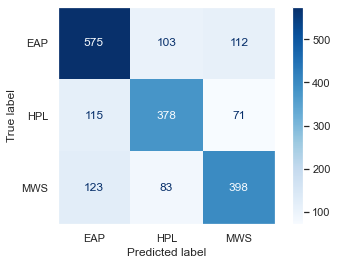

In [14]:
evaluate_model(
    model.best_estimator_,
    'Best Estimator',
    xtrain_glove_ns, ytrain,
    xvalid_glove_ns, yvalid,
)

In [15]:
history

train            validate          
                 logloss  accuracy   logloss  accuracy
Best Estimator  0.405324  0.930094  0.785424  0.685667